In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# Read in the data
team_flights = pd.read_csv('data/team_flights.csv')
fuel_prices = pd.read_csv('data/fuel_prices_2101.csv', index_col='date')

team_flights.head()

,team_name,departure_datetime,landing_datetime,travel_distance_miles
0,Agile Antelopes,2102-04-06 21:37:00,2102-04-07 00:35:57,1491.250000
1,Agile Antelopes,2102-04-10 23:57:00,2102-04-11 01:35:40,822.222222
2,Agile Antelopes,2102-04-14 00:29:00,2102-04-14 05:02:55,2282.638889
3,Agile Antelopes,2102-04-21 03:31:00,2102-04-21 05:23:09,934.583333
4,Agile Antelopes,2102-04-24 22:23:00,2102-04-25 00:25:50,1023.611111


In [24]:
# Inspect data
team_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team_name              1145 non-null   object 
 1   departure_datetime     1145 non-null   object 
 2   landing_datetime       1145 non-null   object 
 3   travel_distance_miles  1145 non-null   float64
dtypes: float64(1), object(3)
memory usage: 35.9+ KB


In [25]:
# Data cleaning and pre-processing
# Change depature_datetime to datetime
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
# Change landing_dattime to datetime
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

# Create a timeseries that shows how many teams will be "in flight" throughout the 2102 season

In [28]:
# Identify the min time between any two unique flight event times
all_datetimes = pd.concat([team_flights['departure_datetime'], team_flights['landing_datetime']])

# Sort the array of datetimes
all_datetimes_sorted = sorted(list(set(all_datetimes)))
all_datetimes_sorted.append(pd.to_datetime('2102-04-01 00:00:00'))
all_datetimes_sorted.append(pd.to_datetime('2102-10-05 00:00:00'))

# Convert all_datetimes_sorted to data frame
in_flight_df = pd.DataFrame({'date':sorted(all_datetimes_sorted),
                             'in_flight':0})
# Then iterate through each known flight, and increment corresponding rows of in_flight_df
for index, flight in team_flights.iterrows():
    in_flight_df.loc[(in_flight_df['date']>=flight['departure_datetime']) &
                     (in_flight_df['date']<flight['landing_datetime']),'in_flight'] += 1

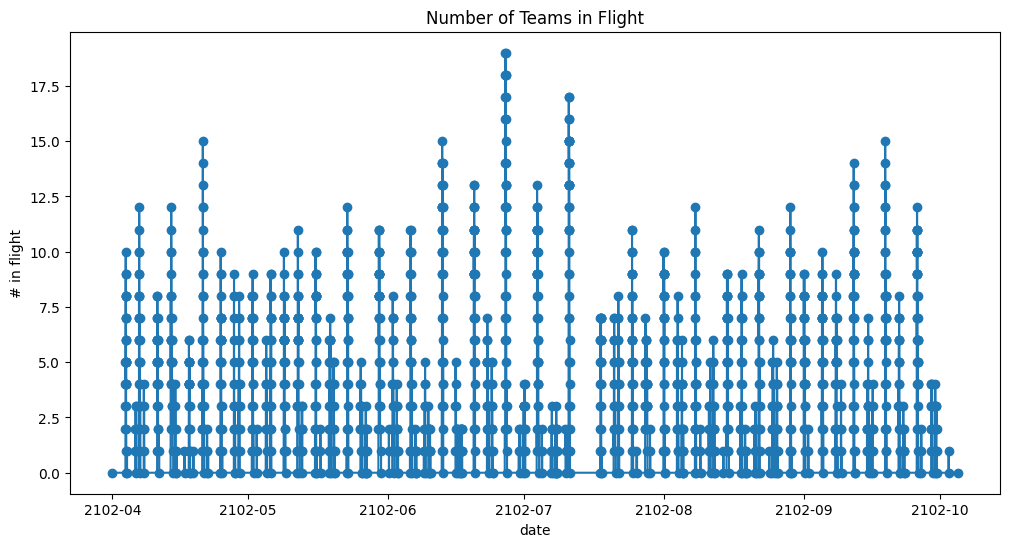

In [33]:
# Plot 
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.step(in_flight_df['date'], in_flight_df['in_flight'], where='post')
ax.scatter(in_flight_df['date'], in_flight_df['in_flight'])
ax.set_xlabel('date') 
ax.set_ylabel('# in flight') 
ax.set_title('Number of Teams in Flight')
plt.show()

max_teams_in_flight = 19  

# Use 2101's jet fuel prices to project jet fuel prices for 2102

In [35]:
# Project fuel prices into 2102 using ARIMA Model
model = SARIMAX(fuel_prices,
              order=(1, 1, 1),             
              seasonal_order=(1, 0, 0, 7)  # for 7 day periodicity
              )
model_fit = model.fit()

# Forecast fuel prices for 2102
forecast = model_fit.get_forecast(steps=365) # Forecsast for every day of year

# Convert to data frame
fuel_prices_forecast = pd.DataFrame(data={"date": forecast.summary_frame().index.to_timestamp(), 
                                          "price":forecast.predicted_mean.values})


/home/workbench/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
# Apply to flight data
team_flights['departure_date'] = team_flights['departure_datetime'].dt.date

# Join fuel_prices dataframe based on the date
fuel_prices_forecast['date'] = fuel_prices_forecast['date'].dt.date
fuel_prices_forecast.set_index('date',inplace=True)
merged_df = team_flights.join(fuel_prices_forecast, on='departure_date', how='left')

# Calculate the fuel cost for flights
merged_df['fuel_cost_total'] = merged_df['price'] * merged_df['travel_distance_miles']

# Calculate the overall fuel cost
total_fuel_spend_2102_dollars = merged_df['fuel_cost_total'].sum()
total_fuel_spend_2102_dollars

np.float64(1858731.4694050648)